In [72]:
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, HMCGibbs
import numpy as np
import jax
import jax.numpy as jnp
import jax.random as random
from jax.config import config
from tqdm import tqdm
import ott
from ott.geometry.geometry import Geometry
from ott.solvers.linear import sinkhorn
import matplotlib.pyplot as plt
config.update("jax_enable_x64", True)
key = random.PRNGKey(0)

In [124]:
# Dimensions of the marginals
M, N = 18, 21

# Define "true" marginals
mu = jnp.ones(M) / M # uniform marginal

nu = jnp.array([i**2 for i in range(1, N+1)]) 
nu = nu / jnp.sum(nu)

# Define "true" cost
iota = 1e-6
C = jnp.array([[iota + (i - j)**2 for j in range(N)] for i in range(M)], dtype=jnp.float64)

# Normalize cost
C = C/C.sum(axis=0, keepdims=True)

# Generate a transport plan
eps = 5e-2
T = sinkhorn.solve(Geometry(cost_matrix=C, epsilon=eps), a=mu, b=nu).matrix

# Generate A and B
A, B = T.sum(axis=1), T.sum(axis=0)

# exp(-C/epsilon)
M = jax.lax.exp(-C/eps)

In [201]:
# Define prior parameters
u_0, v_0 = 1.0, 1.2
u_1, v_1 = 1.0, 0.01

key, key_a, key_b, key_c = random.split(key, 4)

# Draw an initial guess
alpha = numpyro.sample("alpha", dist.Gamma(u_0, v_0), rng_key=key_a, sample_shape=mu.shape)
beta = numpyro.sample("beta", dist.Gamma(u_1, v_1), rng_key=key_b, sample_shape=nu.shape) 

# Make an initial guess for M
_M = jax.random.uniform(key=key_c, shape=M.shape)
_M /= _M.sum(axis=0, keepdims=True)
_M = jax.lax.exp(-_M/eps)

# Collect samples
alpha_res, beta_res, y_res, M_res = [], [], [], []

# Model definition
def Gibbs(_a, _b, _m, _key_a, _key_b, _key_c):
     _alpha = numpyro.sample("alpha", dist.Gamma(A + u_0 - 1, v_0 + jnp.matmul(_m, _b)), rng_key=_key_a)
     _beta = numpyro.sample("beta", dist.Gamma(B + u_1 - 1, v_1 + jnp.matmul(_a, _m)), rng_key=_key_b)
     _a_b = alpha.reshape(-1, 1) * beta.reshape(1, -1)
     _y = _a_b * _m
     _m_new = numpyro.sample("_M", dist.Gamma(_y+1, _a_b), rng_key=_key_c)
     return _alpha, _beta, _y, _m_new

# Sample
n_samples, burn_in = 10000, 100
for _ in tqdm(range(n_samples), desc="Sampling"):
    key, key_a, key_b, key_c = random.split(key, 4)
    alpha, beta, _y, _M = Gibbs(alpha, beta, M, key_a, key_b, key_c)
    if _ > burn_in:
        alpha_res.append(alpha)
        beta_res.append(beta)
        y_res.append(_y)
        M_res.append(_M)

Sampling: 100%|██████████████████████████████████████████████████████| 10000/10000 [00:12<00:00, 828.00it/s]


Text(0.5, 1.0, 'recovered marginal 2')

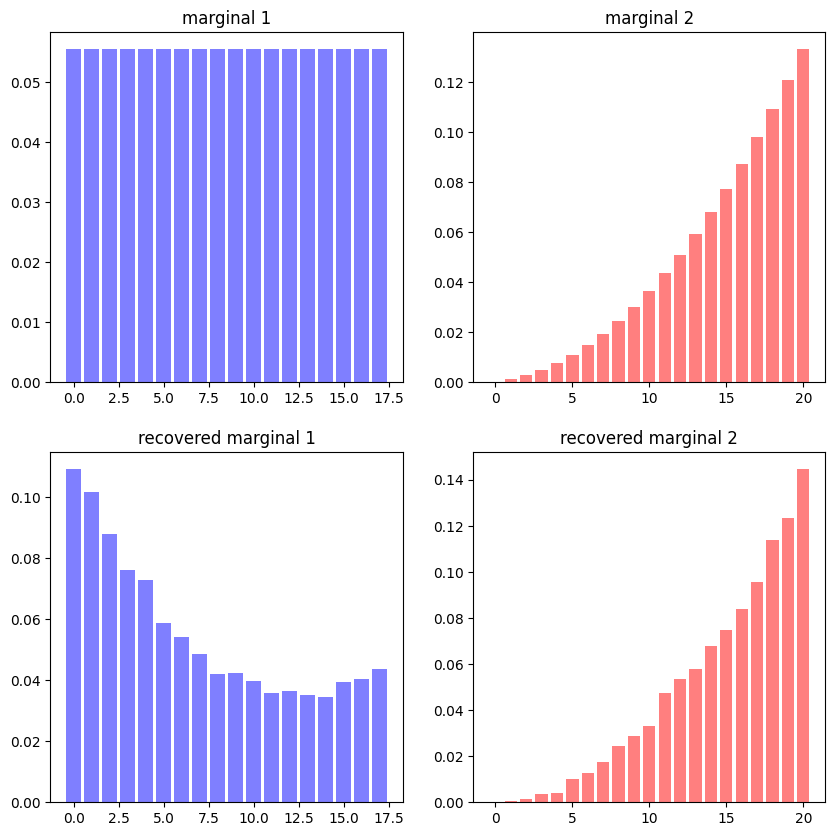

In [202]:
# plot the marginals
fig, axs = plt.subplots(2,2, figsize=(10, 10))
axs[0, 0].bar(range(mu.shape[0]), mu, color='blue', alpha=0.5)
axs[0, 0].set_title('marginal 1')

axs[0, 1].bar(range(nu.shape[0]), nu, color='red', alpha=0.5)
axs[0, 1].set_title('marginal 2')

alpha_est = np.array(alpha_res).mean(axis=0)
alpha_est /= np.sum(alpha_est)
axs[1, 0].bar(range(alpha.shape[0]), alpha_est, color='blue', alpha=0.5)
axs[1, 0].set_title('recovered marginal 1')

beta_est = np.array(beta_res).mean(axis=0)
beta_est /= np.sum(beta_est)
axs[1, 1].bar(range(beta.shape[0]), beta_est, color='red', alpha=0.5)
axs[1, 1].set_title('recovered marginal 2')

Text(0.5, 1.0, 'Inferred transport map')

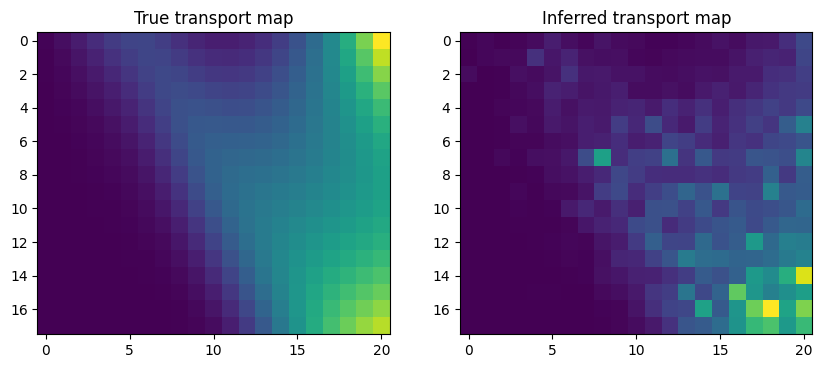

In [203]:
fig, axs = plt.subplots(1, 2, figsize=(10, 8))
T_inf = np.array(y_res).mean(axis=0)
axs[0].imshow(T)
axs[0].set_title("True transport map")
axs[1].imshow(T_inf)
axs[1].set_title("Inferred transport map")

In [204]:
M_res[-1]

Array([[            inf,             inf, 2.37999424e+016,
        6.01898566e+173, 5.23131320e+013, 5.10602266e+037,
        1.36125650e+014, 6.83242508e+015, 1.38775663e+007,
        1.15986647e+019, 4.56646771e+034, 1.06775456e+014,
        7.44371274e+006, 7.19432756e+011, 7.76255461e+003,
        5.41567018e+003, 2.57185810e+020, 2.29298426e+004,
        3.08419012e+003, 2.96706933e+016, 2.46014777e+001],
       [            inf,             inf, 1.50795682e+017,
        2.02608415e+178, 1.88282829e+017, 4.35489411e+041,
        3.24485865e+018, 9.46608256e+019, 6.23314239e+010,
        9.09193501e+022, 1.03124699e+040, 8.50345594e+018,
        1.69447997e+011, 2.65351795e+015, 1.27141486e+008,
        4.08954694e+007, 3.64506642e+023, 4.43211495e+008,
        1.23857226e+007, 6.21131217e+018, 2.24728362e+005],
       [            inf,             inf, 4.21318373e+040,
        1.63299517e+198, 4.71516658e+037, 3.42050257e+061,
        9.02031179e+037, 2.81941006e+039, 4.63579506e+